# Assignment 3 
# (Author: Jan Klinkosz, id number: 394 342, kaggle nick: Johny7013)

First of all we need to import python modules that are necessary to run

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
import numpy as np
import time
import matplotlib.pyplot as plt

Neural network class

In [2]:
class MyNet2(nn.Module):
    def __init__(self):
        super(MyNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 2, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        # self.fc3 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2, 2)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.max_pool2d(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.max_pool2d(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return self.log_softmax(x)



Function used for training

In [3]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss_f = nn.NLLLoss()
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

Function for generating predictions

In [4]:
def generate_predictions(model, device, test_loader):
    model.eval()

    predictions = np.zeros((len(test_loader.dataset), 2))
    predictions.astype(int)
    i = 0

    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            predictions[i][0] = i
            predictions[i][1] = pred
            i += 1

    np.savetxt('data.csv', predictions, fmt='%d', delimiter=',', header='Id,Class')

Training settings

In [5]:
batch_size = 100
test_batch_size = 100
epochs = 8
epochs2 = 15
epochs3 = 8
lr = 0.01
momentum = 0.7
seed = 1
log_interval = 100
save_model = False
use_cuda = True

General Settings

In [6]:
torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 6, 'pin_memory': True} if use_cuda else {}

# values needed to normalise input
normalizer = 1. / 256.
const_half = 0.5

Loading data and providing augmantation
(unfortunately I had problems with loading data from file so I used pytorch loaders to load them form internet)

In [7]:
# load standard images
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((const_half,), (normalizer,))
                          ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# train model on the same images but transformed a little with affine tranformations (augemnation)
train_loader2 = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.RandomAffine(1, translate=(0, 0.1)),
                              transforms.ToTensor(),
                              transforms.Normalize((const_half,), (normalizer,))
                          ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# This wasn't used (train_loader3) becasue gave really poor results, but it's kind of augmentation i.e. 
# rotate vertically all images and train model on them. Perhaps there were great problems with shoes, 
# because all of them are directed to the left of an image, so when net learn on images with shoes 
# directed to the left I assume it's going to freak out when it gets shoes directed to the right
#train_loader3 = torch.utils.data.DataLoader(
#    datasets.FashionMNIST('./data', train=True, download=True,
#                          transform=transforms.Compose([
#                              transforms.RandomVerticalFlip(1),
#                              transforms.ToTensor(),
#                              transforms.Normalize((const_half,), (normalizer,))
#                          ])),
#    batch_size=batch_size, shuffle=True, **kwargs)

# load test data
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((const_half,), (normalizer,))
                          ])),
    batch_size=1, shuffle=False, **kwargs)

# Solution number 1

Defining model & optimizer

In [8]:
model = MyNet2().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Training

In [9]:
for epoch in range(1, epochs + 1):
    train(log_interval, model, device, train_loader, optimizer, epoch)

for epoch in range(1, epochs2 + 1):
    train(log_interval, model, device, train_loader2, optimizer, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.611808
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.622516
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.494013
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.537474
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.414850
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.424023
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.524124
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.278110
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.256294
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.408024
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.271528
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.336547
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.235343
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.224895
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.235742
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.250919
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.303147
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.188056
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.203110
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.216504
Train Epoch: 4 [2000

Generate predictions

In [10]:
generate_predictions(model, device, test_loader)

Save model if you want

In [11]:
if (save_model):
    torch.save(model.state_dict(), "fashion_network.pt")

# Solution number 2

Similar to the first one. Small differences in training settings and no augmentation used.

In [12]:
lr = 0.001
momentum = 0.9

model = MyNet2().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(log_interval, model, device, train_loader, optimizer, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.597305
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.742822
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.622854
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.521695
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.345448
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.575120
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.555804
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.402487
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.262993
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.341025
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.474761
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.389250
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.245732
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.372512
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.254649
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.293042
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.411458
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.243275
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.217652
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.259772
Train Epoch: 4 [2000

# Visualisation

You can see results of normalisation on images

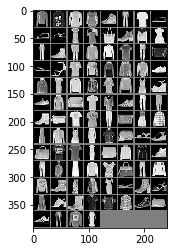

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


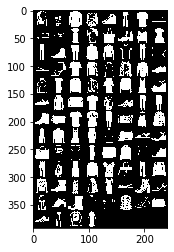

In [15]:
def imshow(img):
    img_un = img * normalizer + const_half # unnormalize
    npimg = img_un.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    #normalised

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

Due to lack of time caused by exam session and problems with loading data. There was no time for approprite testing. I decided to train my model on all data and test my ideas on kaggle. I know that is not a right approach but it's some.